In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a6bc1638-8b3c-5091-e437-7a0edbd90e1b)


In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.4359663619999878
GPU (s):
0.03133630500002482
GPU speedup over CPU: 45x


In [23]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed May 26 14:20:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    34W / 250W |   1615MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
pip install keras-utils


  Created wheel for keras-utils: filename=keras_utils-1.0.13-cp37-none-any.whl size=2657 sha256=069dd0b51d94d66fe577e9aa04763ac8fdfda27f2345d8bc166a0ddcf9013f66
  Stored in directory: /root/.cache/pip/wheels/46/25/27/7707005c1cb27e1ffc8277b004ac295e34767b02b44d73d6be
Successfully built keras-utils


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2

# For preprocessing and model building
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline
from keras.models import model_from_json
from keras.models import load_model

In [13]:
!fusermount -u drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [15]:
path = '/content/gdrive/MyDrive/Project'
os.listdir(path)

['train.csv', 'fashion.zip', 'fashion']

In [16]:
# Reading .csv file
train_df = pd.read_csv(path + '/train.csv')
train_df.head()

,files,target,images
0,../input/fashiondata/data/shoes/5da81ceb7861c2...,shoes,5da81ceb7861c2af6a5a89a7_1.jpg
1,../input/fashiondata/data/beauty/5da81d8a7861c...,beauty,5da81d8a7861c2af6a5a901c_3.jpg
2,../input/fashiondata/data/beauty/5da820f26504f...,beauty,5da820f26504fb65da0043e6_0.jpg
3,../input/fashiondata/data/jewelry and watches/...,jewelry and watches,5da81c026504fb65cea700d2_0.jpg
4,../input/fashiondata/data/bags/5da81d2c7861c2a...,bags,5da81d2c7861c2af6a5a8c64_2.jpg


In [17]:
# Get hot-encoded labels for targets
df2 = pd.get_dummies(train_df, columns=['target'])
display(df2)

,files,images,target_bags,target_beauty,target_jewelry and watches,target_shoes
0,../input/fashiondata/data/shoes/5da81ceb7861c2...,5da81ceb7861c2af6a5a89a7_1.jpg,0,0,0,1
1,../input/fashiondata/data/beauty/5da81d8a7861c...,5da81d8a7861c2af6a5a901c_3.jpg,0,1,0,0
2,../input/fashiondata/data/beauty/5da820f26504f...,5da820f26504fb65da0043e6_0.jpg,0,1,0,0
3,../input/fashiondata/data/jewelry and watches/...,5da81c026504fb65cea700d2_0.jpg,0,0,1,0
4,../input/fashiondata/data/bags/5da81d2c7861c2a...,5da81d2c7861c2af6a5a8c64_2.jpg,1,0,0,0
...,...,...,...,...,...,...
5995,../input/fashiondata/data/jewelry and watches/...,5db865b0d5424ee1f33537b6_2.jpg,0,0,1,0
5996,../input/fashiondata/data/bags/5db81154d5424ee...,5db81154d5424ee1f3352f9c_2.jpg,1,0,0,0
5997,../input/fashiondata/data/bags/5da81d547861c2a...,5da81d547861c2af6a5a8e7d_2.jpg,1,0,0,0
5998,../input/fashiondata/data/beauty/5da81b44b25b0...,5da81b44b25b035d1d17a692_6.jpg,0,1,0,0


In [18]:
# Separating the hot-encoded columns
df1 = df2.drop(['files', 'images'],axis=1)
display(df1)

,target_bags,target_beauty,target_jewelry and watches,target_shoes
0,0,0,0,1
1,0,1,0,0
2,0,1,0,0
3,0,0,1,0
4,1,0,0,0
...,...,...,...,...
5995,0,0,1,0
5996,1,0,0,0
5997,1,0,0,0
5998,0,1,0,0


In [19]:
# Merge with the original dataset
df = train_df.merge(df1, left_index = True, right_index = True)
display(df)

,files,target,images,target_bags,target_beauty,target_jewelry and watches,target_shoes
0,../input/fashiondata/data/shoes/5da81ceb7861c2...,shoes,5da81ceb7861c2af6a5a89a7_1.jpg,0,0,0,1
1,../input/fashiondata/data/beauty/5da81d8a7861c...,beauty,5da81d8a7861c2af6a5a901c_3.jpg,0,1,0,0
2,../input/fashiondata/data/beauty/5da820f26504f...,beauty,5da820f26504fb65da0043e6_0.jpg,0,1,0,0
3,../input/fashiondata/data/jewelry and watches/...,jewelry and watches,5da81c026504fb65cea700d2_0.jpg,0,0,1,0
4,../input/fashiondata/data/bags/5da81d2c7861c2a...,bags,5da81d2c7861c2af6a5a8c64_2.jpg,1,0,0,0
...,...,...,...,...,...,...,...
5995,../input/fashiondata/data/jewelry and watches/...,jewelry and watches,5db865b0d5424ee1f33537b6_2.jpg,0,0,1,0
5996,../input/fashiondata/data/bags/5db81154d5424ee...,bags,5db81154d5424ee1f3352f9c_2.jpg,1,0,0,0
5997,../input/fashiondata/data/bags/5da81d547861c2a...,bags,5da81d547861c2af6a5a8e7d_2.jpg,1,0,0,0
5998,../input/fashiondata/data/beauty/5da81b44b25b0...,beauty,5da81b44b25b035d1d17a692_6.jpg,0,1,0,0


In [20]:
# Drop non-essential column
df = df.drop(['files'],axis=1)
display(df)

,target,images,target_bags,target_beauty,target_jewelry and watches,target_shoes
0,shoes,5da81ceb7861c2af6a5a89a7_1.jpg,0,0,0,1
1,beauty,5da81d8a7861c2af6a5a901c_3.jpg,0,1,0,0
2,beauty,5da820f26504fb65da0043e6_0.jpg,0,1,0,0
3,jewelry and watches,5da81c026504fb65cea700d2_0.jpg,0,0,1,0
4,bags,5da81d2c7861c2af6a5a8c64_2.jpg,1,0,0,0
...,...,...,...,...,...,...
5995,jewelry and watches,5db865b0d5424ee1f33537b6_2.jpg,0,0,1,0
5996,bags,5db81154d5424ee1f3352f9c_2.jpg,1,0,0,0
5997,bags,5da81d547861c2af6a5a8e7d_2.jpg,1,0,0,0
5998,beauty,5da81b44b25b035d1d17a692_6.jpg,0,1,0,0


In [21]:
# Check for null items
df.isnull().sum().sum()

0

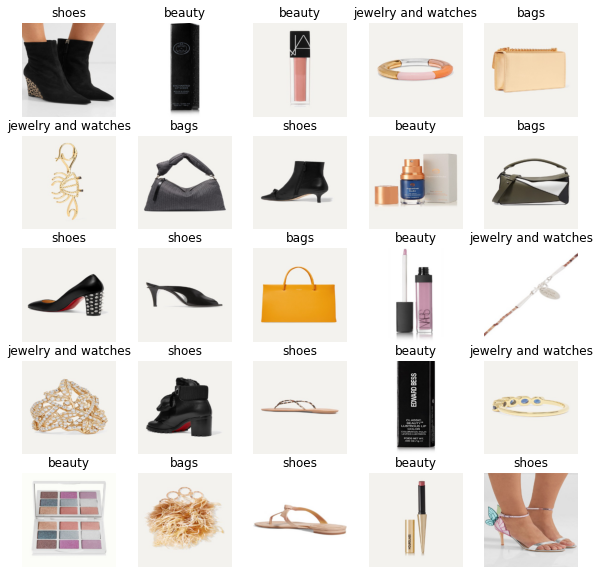

In [22]:
# Plot images wrt the given targets
plt.figure(figsize=(10, 10))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    img = mpimg.imread(path + '/fashion/' + df["images"][i])
    img = cv2.resize(img, (256, 256))
    plt.imshow(img)
    plt.title(df["target"][i])
    plt.axis("off")
    
    X = np.array(df)

In [24]:
# Check names of the columns
train_df.columns

Index(['files', 'target', 'images'], dtype='object')

In [25]:
# Check names of the new dataframe columns
df.columns

Index(['target', 'images', 'target_bags', 'target_beauty',
       'target_jewelry and watches', 'target_shoes'],
      dtype='object')

In [26]:
# Check unique columns
df['target'].unique()

array(['shoes', 'beauty', 'jewelry and watches', 'bags'], dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


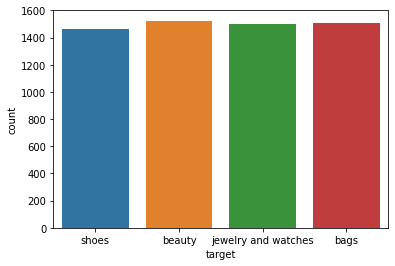

In [27]:
# Countplot to check if data has equal shape
sns.countplot(df['target'])

In [28]:
# Count to check if data has equal sape
df["target"].value_counts()

beauty                 1524
bags                   1508
jewelry and watches    1503
shoes                  1465
Name: target, dtype: int64

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile(path + '/fashion.zip', 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [29]:
# Preprocessing the data
train_image = []
for i in tqdm(range(df.shape[0])):
    img = image.load_img(path + '/fashion/' +df['images'][i],target_size=(256,256,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 6000/6000 [53:51<00:00,  1.86it/s]


In [30]:
# Shape of the array
X.shape

(6000, 256, 256, 3)

'beauty'

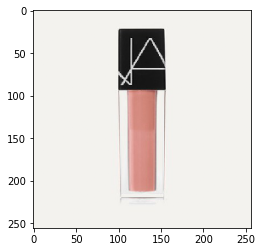

In [31]:
# Plot and visualize preprocessed image
plt.imshow(X[2])

# Plot and visualize preprocessed image
df['target'][2]

In [32]:
y = np.array(df.drop(['target', 'images'],axis=1))
y.shape

(6000, 4)

## __Defining the architecture of the model:__

In [33]:
# Randomly separate 10% of the images as our validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [34]:
# Define the architecture of our model
# 
model = Sequential()
# Layer1
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer2
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer3
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer4
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Defining Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))

In [35]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 64)        5

In [36]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
# Training the model.
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/20
85/85 [==============================] - 20s 70ms/step - loss: 0.6237 - accuracy: 0.2554 - val_loss: 0.5978 - val_accuracy: 0.4417
Epoch 2/20
85/85 [==============================] - 5s 58ms/step - loss: 0.5516 - accuracy: 0.3916 - val_loss: 0.5324 - val_accuracy: 0.5633
Epoch 3/20
85/85 [==============================] - 5s 58ms/step - loss: 0.4769 - accuracy: 0.5460 - val_loss: 0.4032 - val_accuracy: 0.6900
Epoch 4/20
85/85 [==============================] - 5s 58ms/step - loss: 0.4175 - accuracy: 0.6254 - val_loss: 0.3372 - val_accuracy: 0.7650
Epoch 5/20
85/85 [==============================] - 5s 58ms/step - loss: 0.3389 - accuracy: 0.7235 - val_loss: 0.3468 - val_accuracy: 0.7800
Epoch 6/20
85/85 [==============================] - 5s 58ms/step - loss: 0.3134 - accuracy: 0.7430 - val_loss: 0.2719 - val_accuracy: 0.8283
Epoch 7/20
85/85 [==============================] - 5s 59ms/step - loss: 0.2747 - accuracy: 0.7817 - val_loss: 0.2321 - val_accuracy: 0.8083
Epoch 8/20
8

## __Evaluating the made arcitecture:__

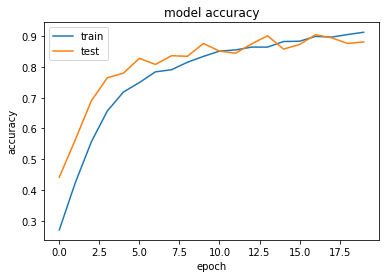

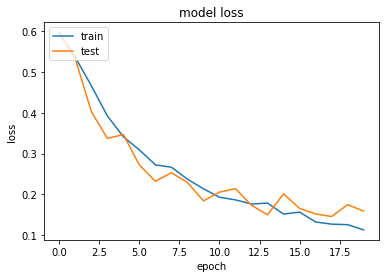

In [38]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [39]:
# evaluate the test set
scores = model.evaluate(X_test, y_test, verbose=0)
print("Final test %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# evaluate the train set
scores = model.evaluate(X_train, y_train, verbose=0)
print("Final train %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Final test accuracy: 88.17%
Final train accuracy: 94.39%


## __Testing the made arcitecture:__

In [41]:
img = image.load_img('/content/drive/MyDrive/Project/fashion/' +'5da81a4e7f3e301b4504b2e5_1.jpg',target_size=(256,256,3))
img = image.img_to_array(img)
img = img/255

target_shoes (0.986)
target_bags (0.0082)
target_jewelry and watches (0.00308)
target_beauty (0.00147)


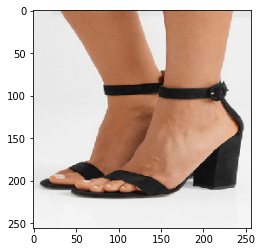

In [42]:
classes = np.array(df.columns[2:])
proba = model.predict(img.reshape(1,256,256,3))
among4 = np.argsort(proba[0])[:-5:-1]
for i in range(4):
    print("{}".format(classes[among4[i]])+" ({:.3})".format(proba[0][among4[i]]))
plt.imshow(img)